In [1]:
import findspark
findspark.init()

In [78]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as sf
from pyspark.sql.functions import col, round, lit, when
from pyspark.sql.types import * 

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import pyodbc

In [3]:
spark = SparkSession.builder.getOrCreate()

# Process Data

In [32]:
def process_log_data(path, file_name, date):
    df = spark.read.json(path + file_name)
    df = df.select('_source.AppName', '_source.Contract', '_source.Mac', '_source.TotalDuration')
    df = df.withColumn('Date', lit(date))
    df = df.rdd.map(lambda x: (x.Contract, x.TotalDuration, x.Date, stateDic.get(x.AppName, 'Error'))).toDF(['Contract', 'TotalDuration', 'Date', 'Type'])
    df = df.groupBy('Contract', 'Date', 'Type').agg({'TotalDuration': 'sum'}).withColumnRenamed('sum(TotalDuration)', 'TotalDuration')
    return df
    
    
    

In [37]:
def main_task():
    path = "D:/Anaconda/A_Python/Big Data/Dataset/"
    file_name = '20220401.json'
    date = '2022-04-01'
    stateDic = {'CHANNEL': 'TV', 'KPLUS': 'TV', 'VOD': 'Movies', 'FIMS': 'Movies', 'SPORT': 'Sports', 'RELAX': 'Relax', 'CHILD': 'Child'}
    df = process_log_data(path, file_name, date)
    
    for i in range(2, 31):
        if (i < 10):
            file_name = '2022040{}.json'.format(i)
            date = '2022-04-0{}'.format(i)
        else:
            file_name = '202204{}.json'.format(i)
            date = '2022-04-{}'.format(i)
        df1 = process_log_data(path, file_name, date)
        df = df.union(df1)
    return df
    

In [38]:
df = main_task()
df = df.cache()

In [39]:
df.count()

43385700

In [40]:
df.select('Date').distinct().count()

30

In [41]:
df.select('Contract').distinct().count()

1920546

Among more than 40M records, there are approximately 2M contracts

In [42]:
df.show(10)

+---------+----------+------+-------------+
| Contract|      Date|  Type|TotalDuration|
+---------+----------+------+-------------+
|HNAAE0691|2022-04-01|    TV|        22465|
|HNH652161|2022-04-01|    TV|        18956|
|NAFD19565|2022-04-01|Movies|        10917|
|SGH501740|2022-04-01|Movies|        11467|
|BDFD19240|2022-04-01|    TV|        18836|
|DLFD06789|2022-04-01|Movies|        15602|
|SGJ137078|2022-04-01|Movies|        24850|
|SGH438981|2022-04-01|Movies|       114685|
|HYFD22583|2022-04-01|    TV|        82697|
|BDD063655|2022-04-01|    TV|        82683|
+---------+----------+------+-------------+
only showing top 10 rows



# Daily Descriptive Analytics

In [43]:
daily_stats = df.groupBy('Date').agg({'Contract': 'count', 'TotalDuration': 'sum'}).withColumnRenamed('count(Contract)', 'TotalUsers').withColumnRenamed('sum(TotalDuration)', 'TotalDuration')

In [51]:
daily_stats = daily_stats.withColumn('TotalDuration', round(col('TotalDuration')/3600, 5))

In [52]:
daily_stats = daily_stats.cache()

In [53]:
daily_stats.show()

+----------+----------+-------------+
|      Date|TotalUsers|TotalDuration|
+----------+----------+-------------+
|2022-04-04|   1448945|7161213.17639|
|2022-04-12|   1430435|7024480.63722|
|2022-04-29|   1451541|6951139.64694|
|2022-04-02|   1470098|6762318.22556|
|2022-04-17|   1467777|7102179.55167|
|2022-04-19|   1449972|7248962.71083|
|2022-04-18|   1431461|7107799.48833|
|2022-04-01|   1483421|7232815.13222|
|2022-04-10|   1407724|6849921.60472|
|2022-04-11|   1464488|7196205.09889|
|2022-04-14|   1438175|6988434.02333|
|2022-04-13|   1448920|6956741.42083|
|2022-04-15|   1447544|6993958.87528|
|2022-04-16|   1493389|7246218.87861|
|2022-04-05|   1442092|7002388.36389|
|2022-04-23|   1454633|  6919591.845|
|2022-04-07|   1443486|6809918.84556|
|2022-04-06|   1443857|6853465.21667|
|2022-04-08|   1440828|7017570.72333|
|2022-04-22|   1455731|7205478.24972|
+----------+----------+-------------+
only showing top 20 rows



In [54]:
visual_1 = daily_stats.toPandas()
visual_1.sort_values(by = 'Date', ascending=True, inplace=True)

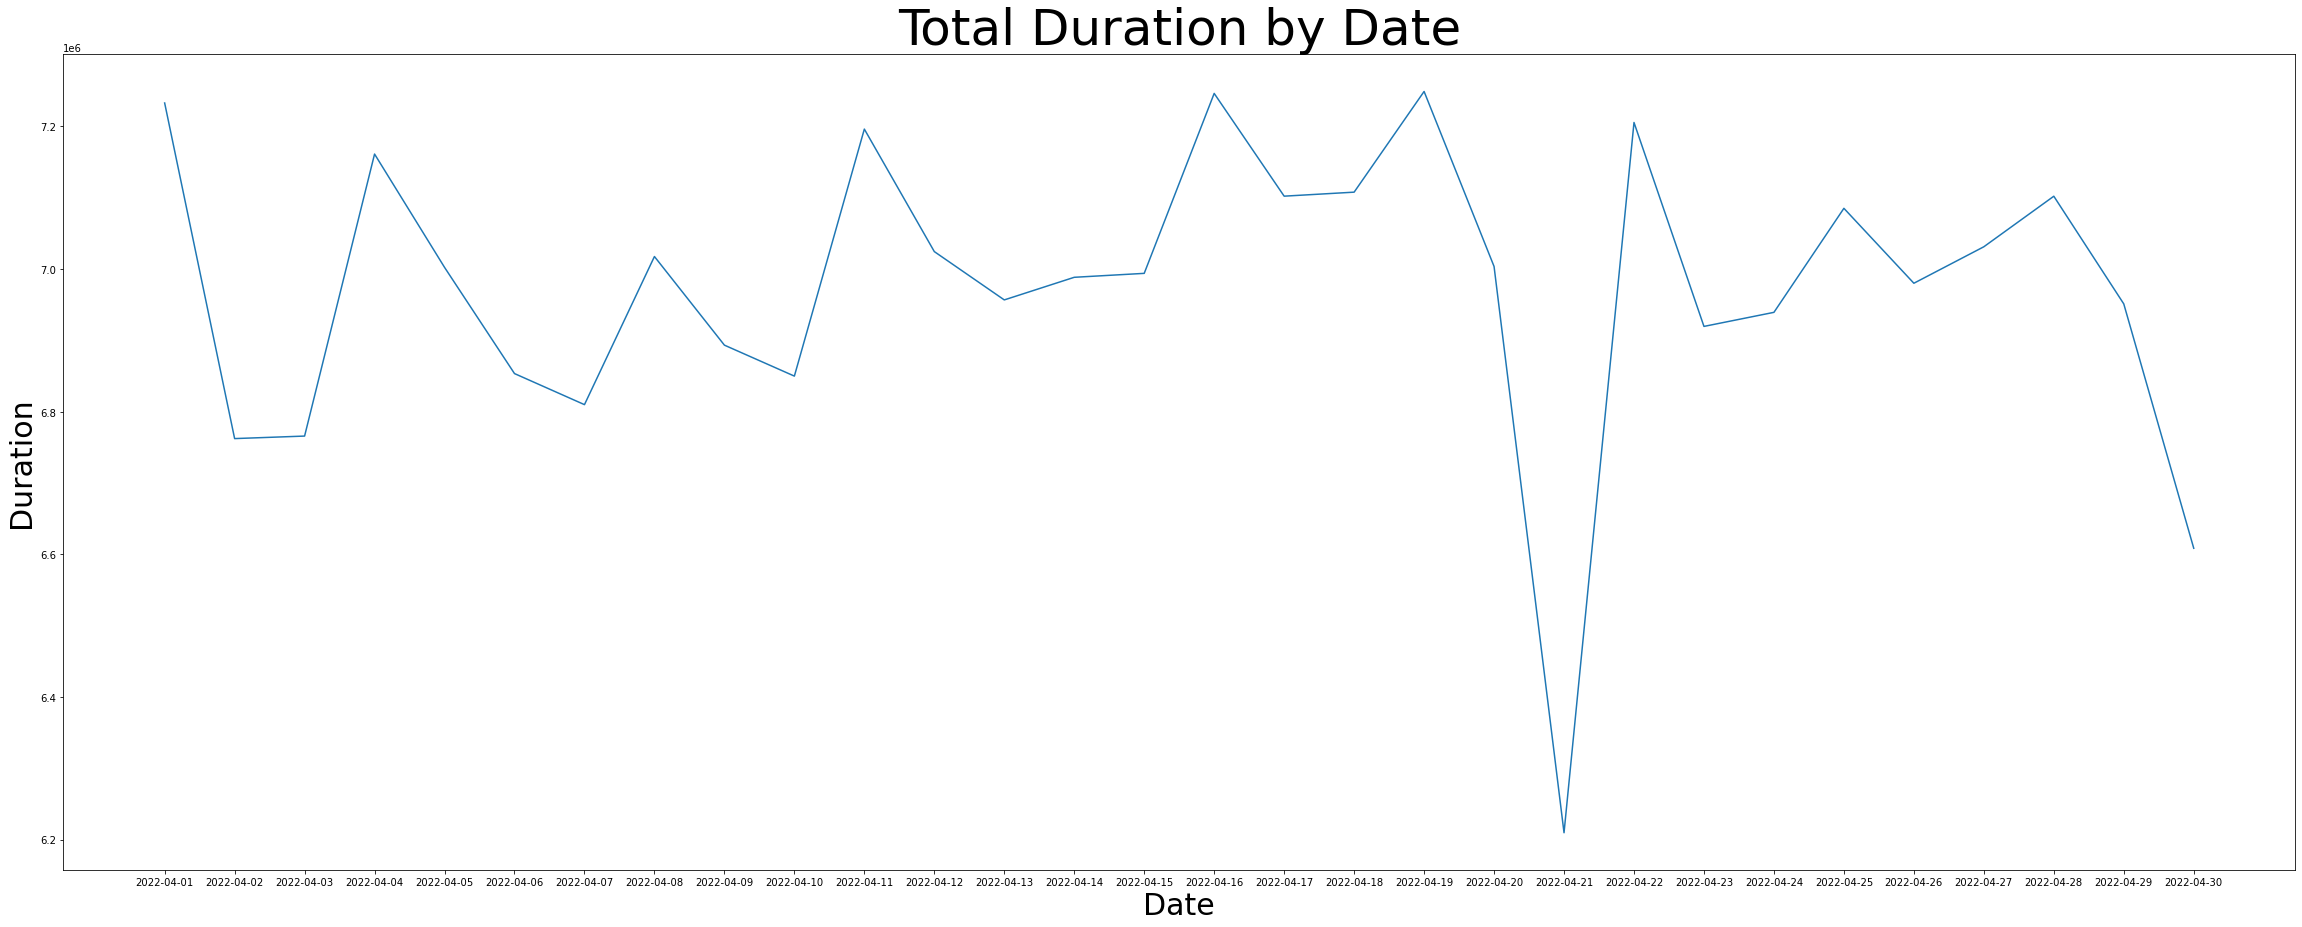

In [69]:
plt.figure(figsize=(40,15))
ax = sns.lineplot(data = visual_1 , x = 'Date' , y ='TotalDuration')
ax.set_title('Total Duration by Date', fontsize=50)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Duration', fontsize=30)
plt.show()

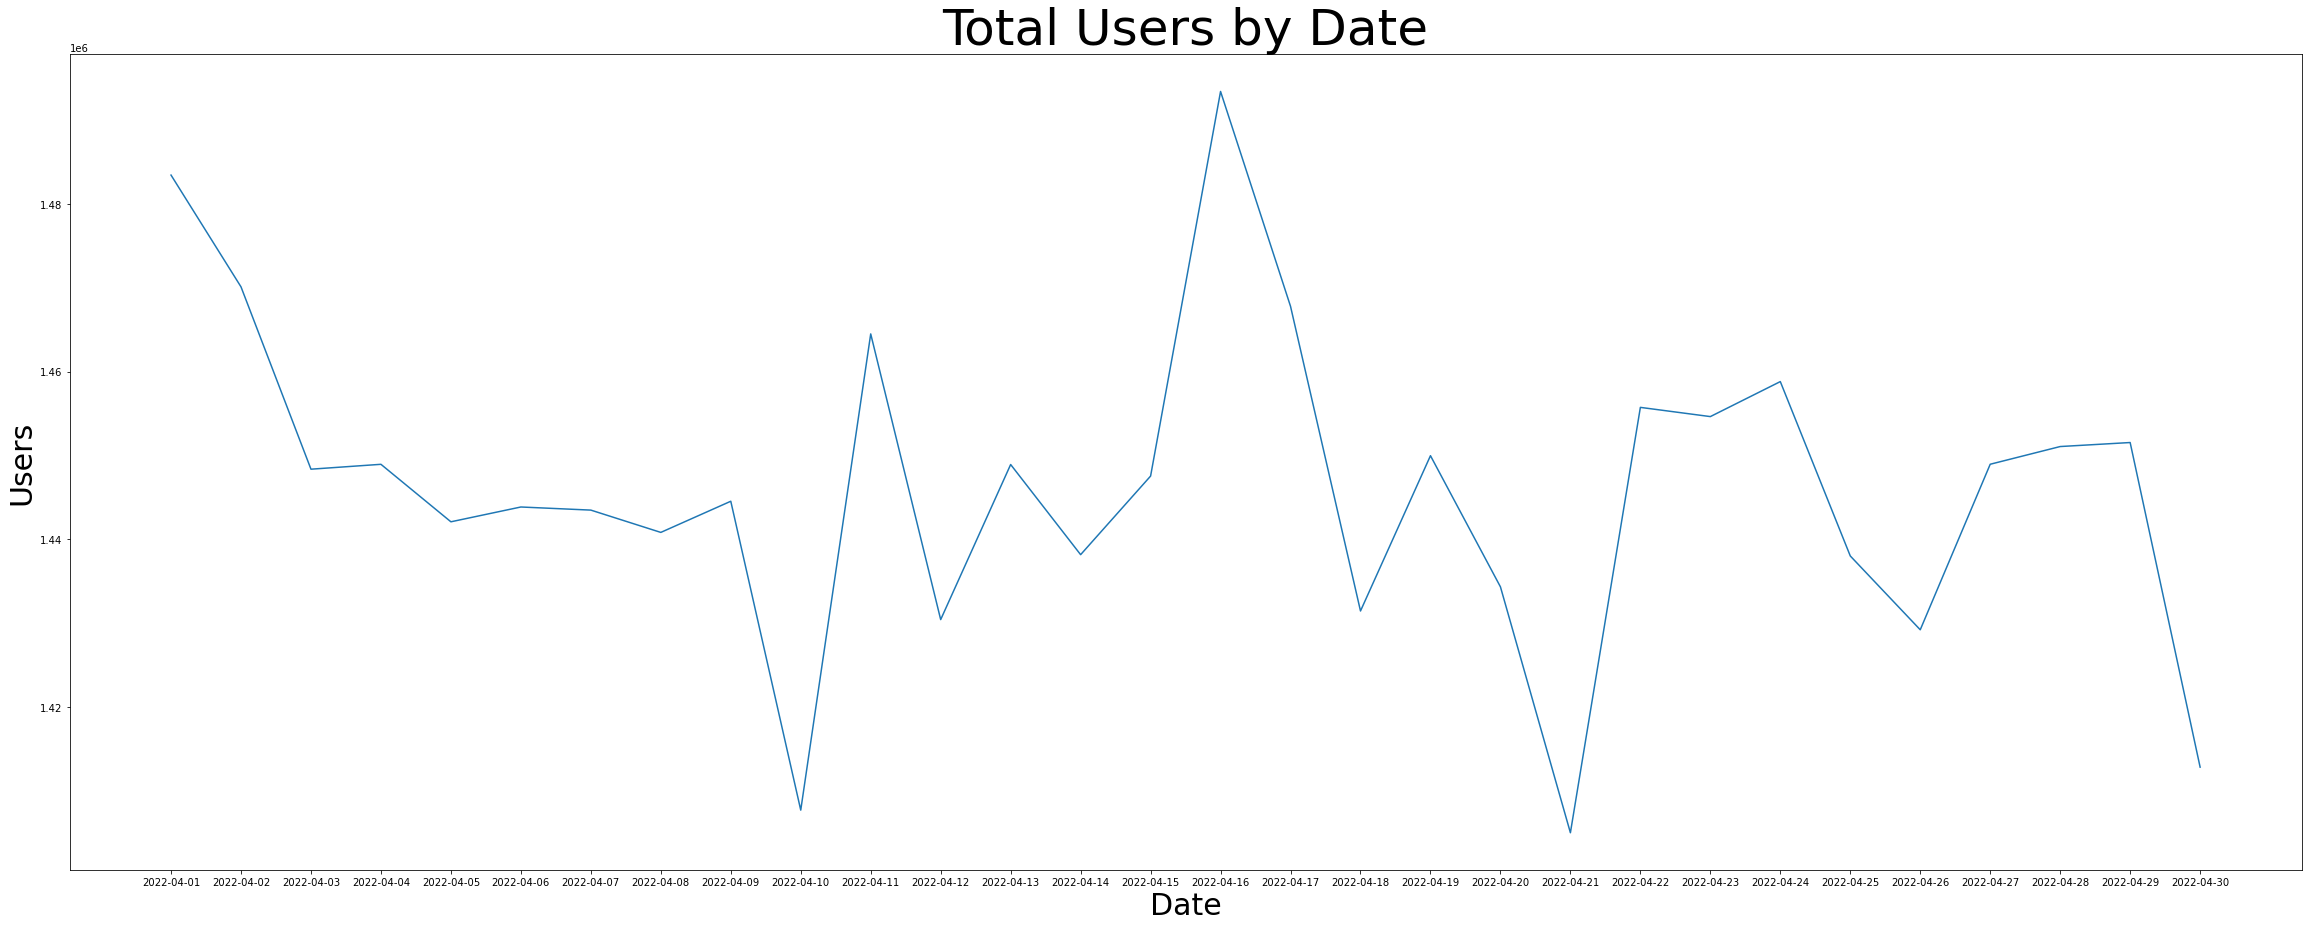

In [70]:
plt.figure(figsize=(40,15))
ax = sns.lineplot(data = visual_1 , x = 'Date' , y ='TotalUsers')
ax.set_title('Total Users by Date', fontsize=50)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Users', fontsize=30)
plt.show()

# Individual Customer Statistics

In [71]:
Customer = df.drop('Date')

In [72]:
Customer = Customer.groupBy('Contract', 'Type').agg({'TotalDuration': 'sum'}).withColumnRenamed('sum(TotalDuration)', 'TotalDuration')

In [73]:
Customer.show(10)

+---------+------+-------------+
| Contract|  Type|TotalDuration|
+---------+------+-------------+
|HNH916839|    TV|       263206|
|QNFD83472|Movies|        13684|
|SGH471092|    TV|       337190|
|PYD000572|    TV|      2609836|
|DLFD11016|    TV|       450878|
|TVFD05602|    TV|       223410|
|HNH332233|    TV|       391863|
|SGH409188|    TV|       343347|
|HND096466|    TV|        43219|
|HNJ064267|    TV|       133721|
+---------+------+-------------+
only showing top 10 rows



In [74]:
visual_2 = Customer.toPandas()

In [ ]:
plt.figure(figsize=(40,15))
ax = sns.barplot(data=visual_2, x="TotalDuration")
ax.set_title('Total Duration', fontsize=50)
plt.show()



# Daily Categories Statistics

In [87]:
stateDic = {'CHANNEL': 'TV', 'KPLUS': 'TV', 'VOD': 'Movies', 'FIMS': 'Movies', 'SPORT': 'Sports', 'RELAX': 'Relax', 'CHILD': 'Child'}
    

In [88]:
cat_stats = df.groupBy('Type', 'Date').agg({'Contract': 'count', 'TotalDuration': 'sum'}).withColumnRenamed('count(Contract)', 'TotalUsers').withColumnRenamed('sum(TotalDuration)', 'TotalDuration')

In [89]:
cat_stats = cat_stats.withColumn('TotalDuration', round(col('TotalDuration')/3600, 5))

In [95]:
cat_stats = cat_stats.cache()

In [91]:
cat_stats.show()

+------+----------+----------+-------------+
|  Type|      Date|TotalUsers|TotalDuration|
+------+----------+----------+-------------+
| Relax|2022-04-20|      5453|   4918.78833|
| Child|2022-04-10|     34549|  56326.89306|
|    TV|2022-04-14|   1319282|   6789156.02|
|Movies|2022-04-17|     88125| 175414.93111|
|Movies|2022-04-29|     83077| 108333.66917|
| Relax|2022-04-02|     14183|    6572.3975|
|Sports|2022-04-21|      2411|    464.50583|
| Child|2022-04-03|     35671|  59325.69583|
|Sports|2022-04-03|      2601|    580.46778|
| Child|2022-04-05|     31864|  51864.50139|
| Relax|2022-04-06|      5466|   5103.64806|
| Child|2022-04-09|     36744|  59425.30361|
|Movies|2022-04-20|     75858| 138238.34861|
|Sports|2022-04-10|      2898|    504.41333|
| Child|2022-04-06|     31557|  50863.89833|
|Movies|2022-04-07|     82374| -93695.79333|
| Relax|2022-04-08|      5323|   4852.05333|
| Relax|2022-04-26|      5655|   4349.79972|
| Child|2022-04-24|     37164|  56513.02556|
|    TV|20

In [96]:
visual_3 = cat_stats.toPandas()
visual_3.sort_values(by = 'Date', ascending=True, inplace=True)

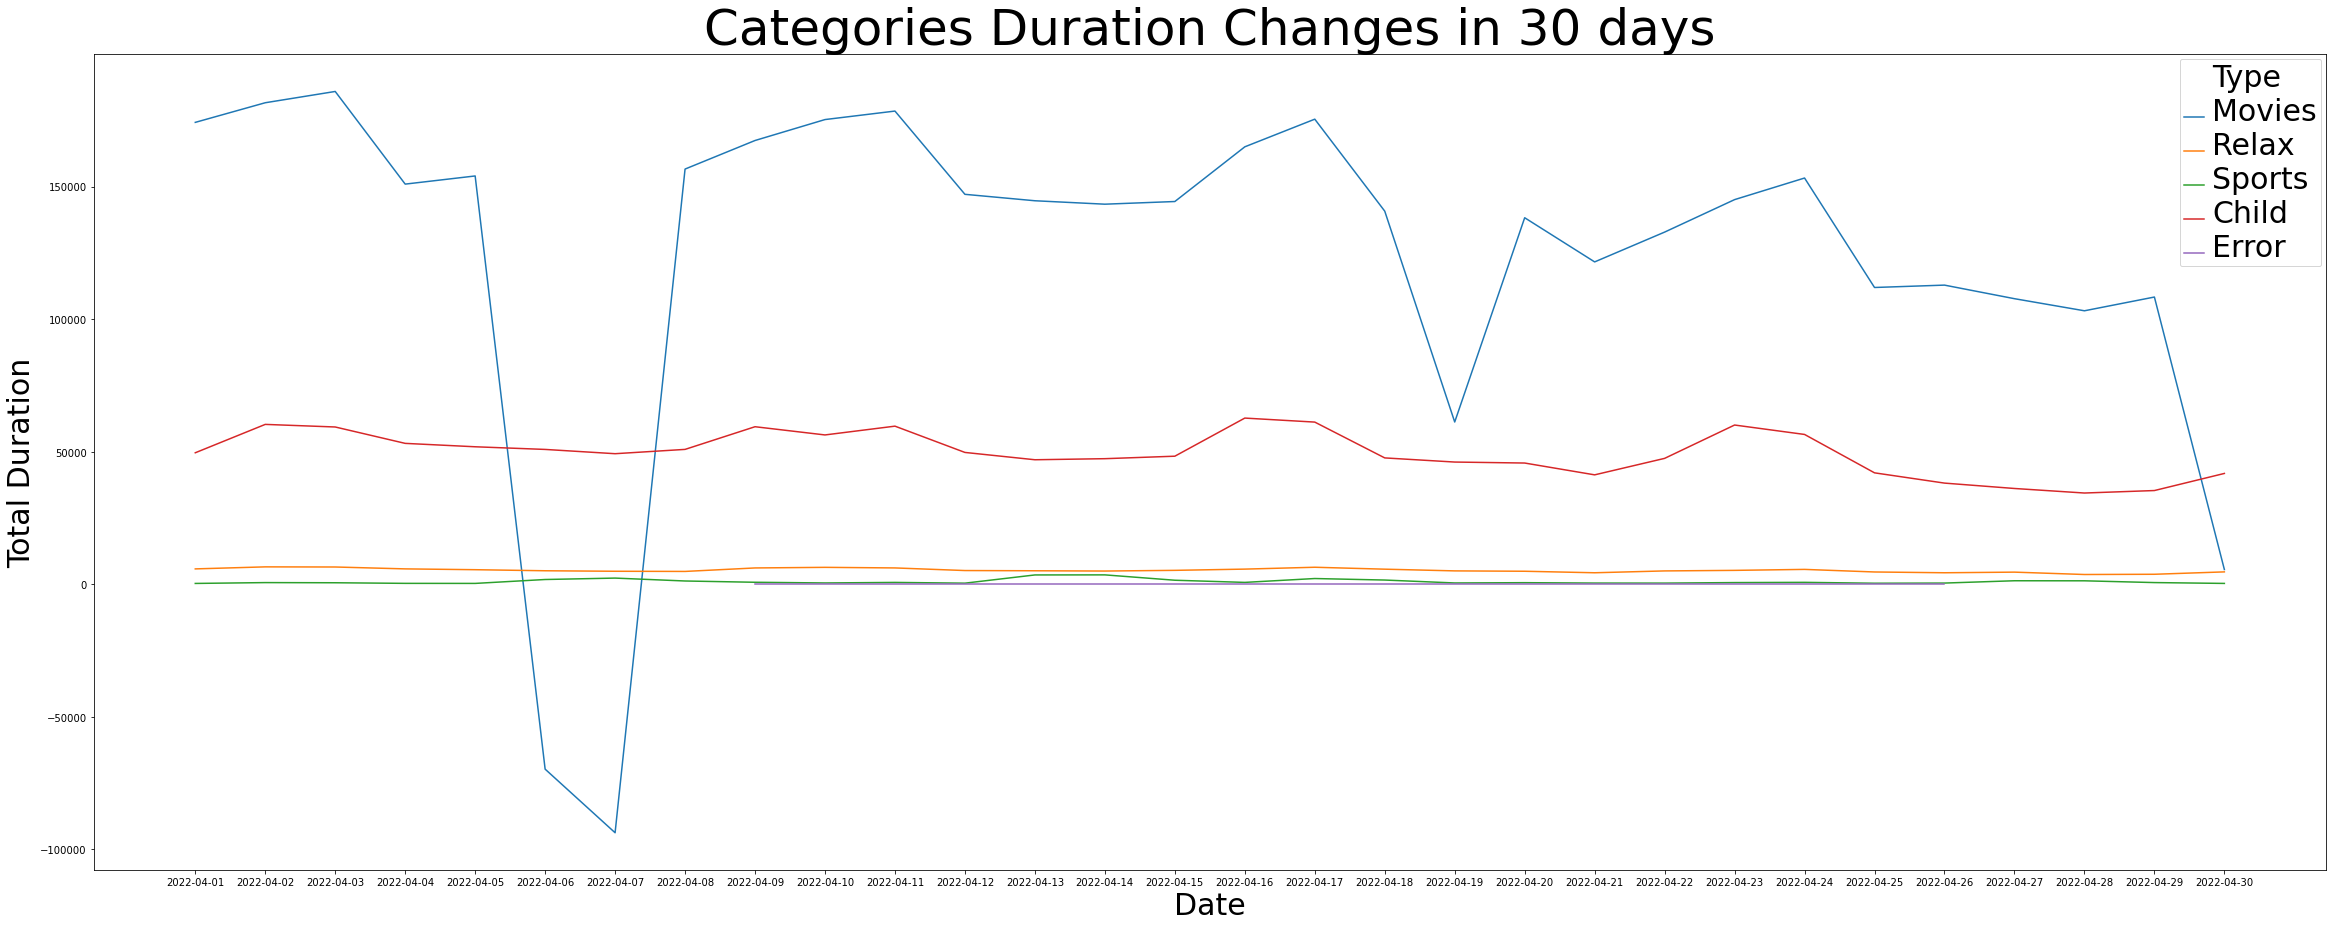

In [120]:
plt.figure(figsize=(40, 15))
ax = sns.lineplot(data=visual_3[visual_3['Type'] != 'TV'], x="Date", y="TotalDuration", hue="Type")
ax.set_title('Categories Duration Changes in 30 days', fontsize=50)

ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Total Duration', fontsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='30')

plt.show()

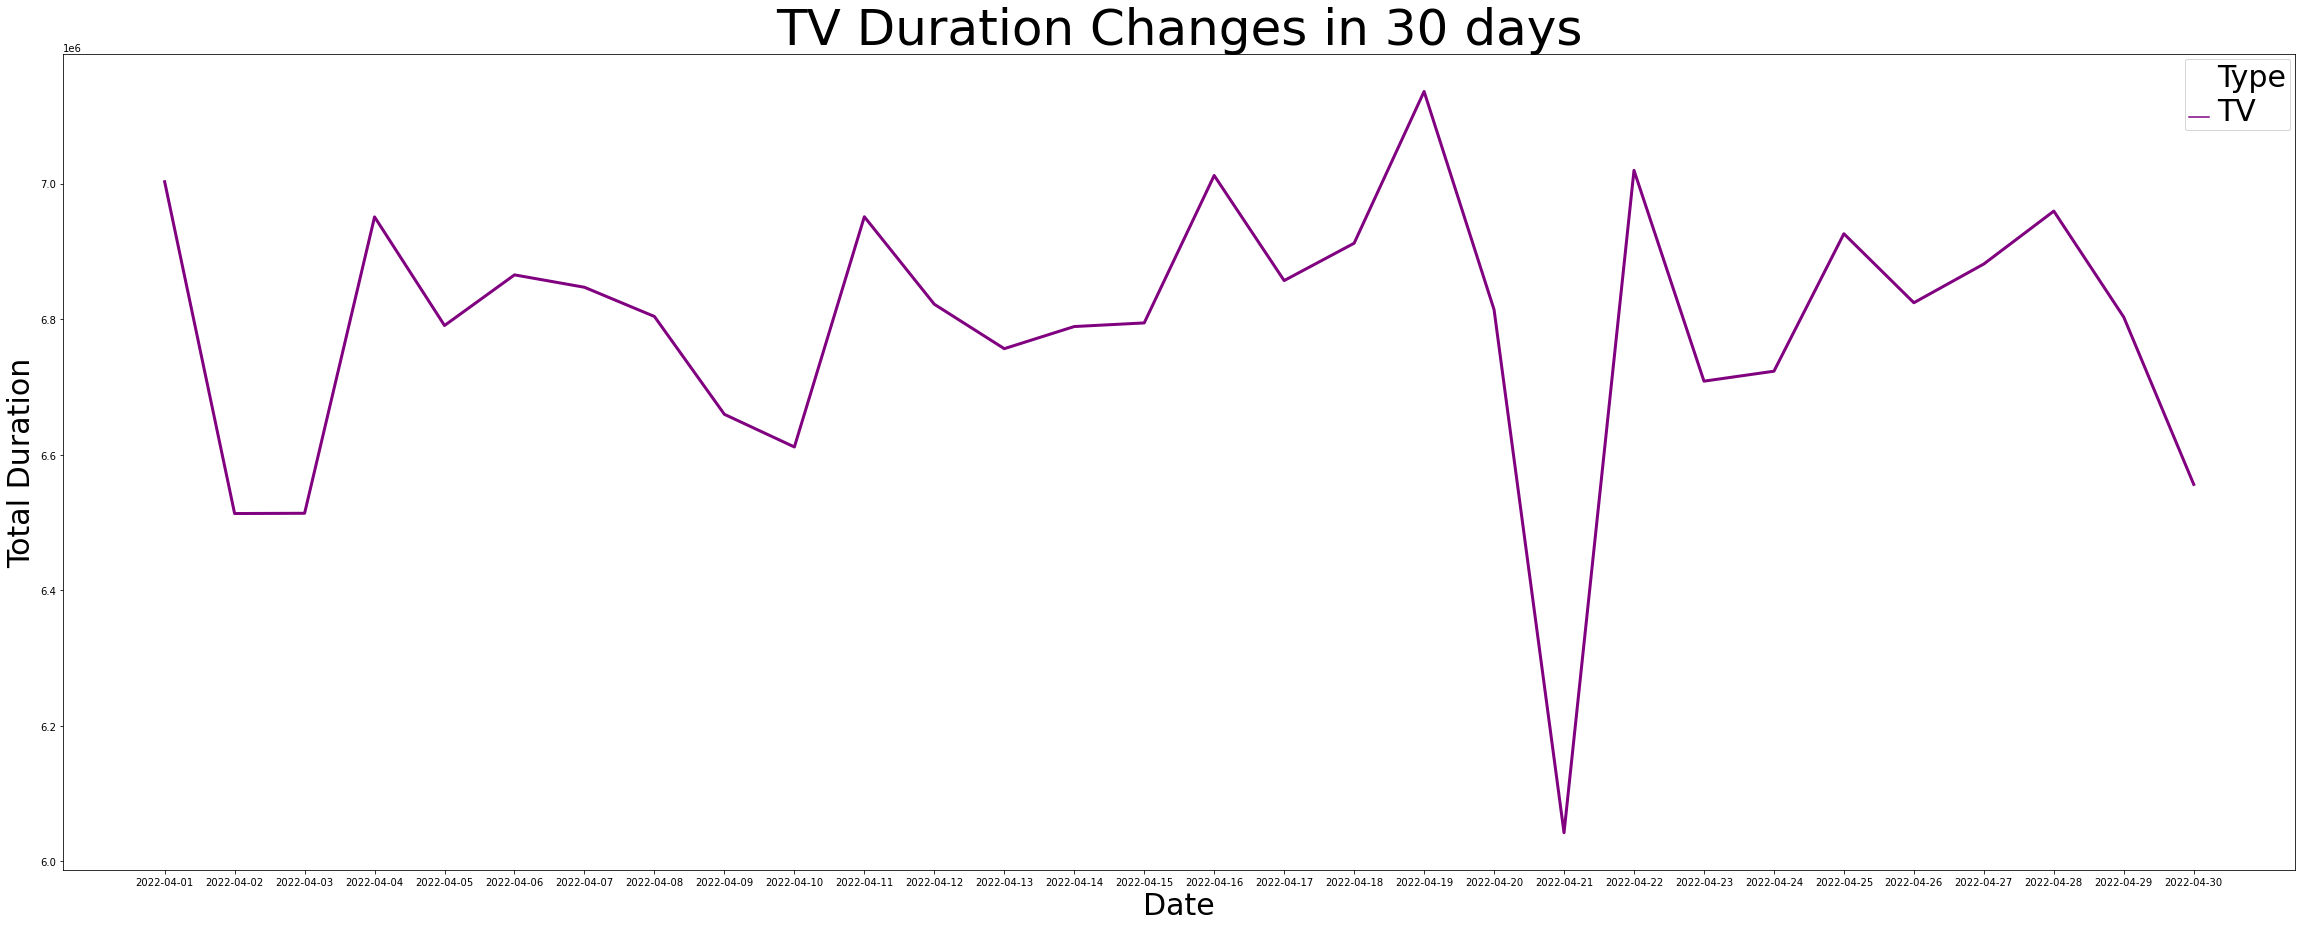

In [126]:
plt.figure(figsize=(40, 15))
ax = sns.lineplot(data=visual_3[visual_3['Type'] == 'TV'], x="Date", y="TotalDuration", hue="Type", palette=['purple'],linewidth=3)
ax.set_title('TV Duration Changes in 30 days', fontsize=50)

ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Total Duration', fontsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='30')

plt.show()

In [132]:
cat_stats_1 = cat_stats.groupBy('Type').agg({'TotalUsers': 'sum', 'TotalDuration': 'sum'}).withColumnRenamed('sum(TotalUsers)', 'TotalUsers').withColumnRenamed('sum(TotalDuration)', 'TotalDuration')

In [133]:
cat_stats_1.show()

+------+----------+--------------------+
|  Type|TotalUsers|       TotalDuration|
+------+----------+--------------------+
| Relax|    211859|  158200.44360000003|
| Child|    987450|       1489625.14637|
|    TV|  39627219|2.0384781751138997E8|
|Movies|   2461705|       3723144.59803|
|Sports|     97465|  31032.260550000003|
| Error|         2|             0.03972|
+------+----------+--------------------+



In [159]:
visual_4 = cat_stats_1.toPandas()
visual_4.sort_values(by = 'TotalDuration', ascending=True, inplace=True)
visual_4.rename({'TotalUsers': 'Users', 'TotalDuration': 'Duration'}, inplace=True)

In [160]:
visual_4 = visual_4.melt(id_vars='Type', value_vars=['TotalUsers', 'TotalDuration'], var_name='Total', value_name='Value')

In [161]:
visual_4

,Type,Total,Value
0,Error,TotalUsers,2.000000e+00
1,Sports,TotalUsers,9.746500e+04
2,Relax,TotalUsers,2.118590e+05
3,Child,TotalUsers,9.874500e+05
4,Movies,TotalUsers,2.461705e+06
5,TV,TotalUsers,3.962722e+07
6,Error,TotalDuration,3.972000e-02
7,Sports,TotalDuration,3.103226e+04
8,Relax,TotalDuration,1.582004e+05
9,Child,TotalDuration,1.489625e+06


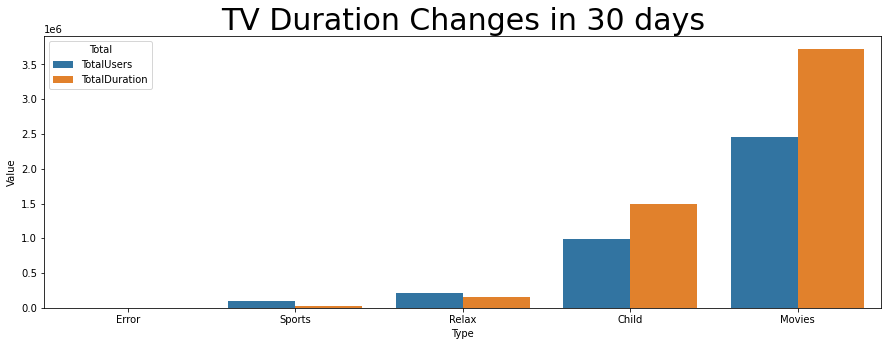

In [164]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=visual_4[visual_4['Type'] != 'TV'], x="Type", y="Value", hue='Total')
ax.set_title('TV Duration Changes in 30 days', fontsize=30)

plt.show()